A [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set) is the set of complex numbers c where:
$$
\begin{array}{c}
c \in \mathbb{C} \\\
z_0 = 0 \\\
z_{n+1} = z_n^2 + c \\\
\lim_{n\to \infty} \lvert z_{n+1}\rvert \le 2
\end{array}
$$


In [1]:
%matplotlib inline

import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
def mset_draw(mset, x=None, y=None):
    if x is not None and y is not None:
        plt.imshow(mset, norm=colors.PowerNorm(0.3), cmap='cubehelix', extent=[x[0], x[-1], y[0], y[-1]]);
    else:
        plt.imshow(mset, norm=colors.PowerNorm(0.3), cmap='cubehelix');
        plt.axis('off');

In [3]:
def create_intervals(xmin, xmax, ymin, ymax, width, height):
    return np.linspace(xmin, xmax, width), np.linspace(ymin, ymax, height)

In [4]:
# Mandelbrot set iteration
def mset_iteration(c, maxiter=256):
    z = c
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z**2 + c
    return n

In [5]:
def mandelbrot_set_list_comp(xmin, xmax, ymin, ymax, width, height, maxiter=256):
    real_range, imaginary_range = create_intervals(xmin, xmax, ymin, ymax, width, height)

    m = [mset_iteration(r + s*1j, maxiter) for r in real_range for s in imaginary_range]
    return m, real_range, imaginary_range

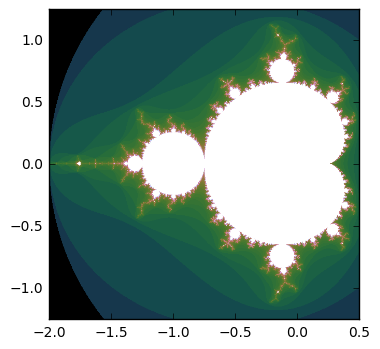

In [6]:
mset, r, i = mandelbrot_set_list_comp(-2.0,0.5,-1.25,1.25, 600, 600)
mset_draw(np.array(mset).reshape(600, 600).T, r, i);

In [7]:
%timeit mandelbrot_set_list_comp(-2.0,0.5,-1.25,1.25, 600, 600)

1 loop, best of 3: 12.8 s per loop


In [8]:
def mandelbrot_set_numpy(xmin, xmax, ymin, ymax, width, height, maxiter=256):
    m = np.empty((height, width), dtype=np.uint8)
    real_range, imaginary_range = create_intervals(xmin, xmax, ymin, ymax, width, height)
    
    for j, i in product(range(height), range(width)):
        x = real_range[i]
        y = imaginary_range[j]
        c = x + y*1j
        m[j,i] = mset_iteration(c, maxiter)

    return m, real_range, imaginary_range

In [9]:
#mset_draw(mandelbrot_set_numpy(-2.0,0.5,-1.25,1.25, 600, 600)[0])

In [10]:
%timeit mandelbrot_set_numpy(-2.0,0.5,-1.25,1.25, 600, 600)

1 loop, best of 3: 13 s per loop


In [11]:
from numba import jit

@jit
def mset_iteration_numba(c, maxiter=256):
    z = c
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z**2 + c
    return n

@jit
def mandelbrot_set_numba(xmin, xmax, ymin, ymax, width, height, maxiter=256):
    m = np.empty((height, width), dtype=np.uint8)
    real_range, imaginary_range = create_intervals(xmin, xmax, ymin, ymax, width, height)

    for j, i in product(range(height), range(width)):
        x = real_range[i]
        y = imaginary_range[j]
        c = x + y*1j
        m[j,i] = mset_iteration_numba(c, maxiter)

    return m, real_range, imaginary_range

In [12]:
#mset_draw(mandelbrot_set_numba(-2.0,0.5,-1.25,1.25, 600, 600)[0])

In [13]:
%timeit mandelbrot_set_numba(-2.0,0.5,-1.25,1.25, 600, 600)

1 loop, best of 3: 1.48 s per loop


In [14]:
def mandelbrot_vectors(c, maxiter):
    output = np.zeros(c.shape)
    z = np.zeros(c.shape, np.complex64)
    for it in range(maxiter):
        notdone = np.less(z.real*z.real + z.imag*z.imag, 4.0)
        output[notdone] = it
        z[notdone] = z[notdone]**2 + c[notdone]
    output[output == maxiter-1] = maxiter-1
    return output

def mandelbrot_set_vectors(xmin, xmax, ymin, ymax, width, height, maxiter=256):
    real_range, imaginary_range = create_intervals(xmin, xmax, ymin, ymax, width, height)

    c = real_range + imaginary_range[:,None]*1j
    return mandelbrot_vectors(c, maxiter)

In [15]:
#mset_draw(mandelbrot_set_vectors(-2.0,0.5,-1.25,1.25, 600, 600))

In [16]:
%timeit mandelbrot_set_vectors(-2.0,0.5,-1.25,1.25, 600, 600)

1 loop, best of 3: 516 ms per loop


In [17]:
%load_ext Cython

In [18]:
%%cython

import cython
import numpy as np
cimport numpy as np

cdef np.uint8_t cp_mset_iteration(double complex c, int maxiter=256):
    cdef:
        double complex z
        int n
        
    z = c
    for n in range(maxiter):
        if z.real**2 + z.imag**2 > 4.0:
            return n
        z = z**2 + c
    return n

@cython.boundscheck(False)
cpdef cp_mandelbrot_set_loop(double xmin, double xmax, double ymin, double ymax, int width, int height, int maxiter=256):
    cdef:
        int j, i
        double x, y
        double[:] real_range = np.linspace(xmin, xmax, width)
        double[:] imaginary_range = np.linspace(ymin, ymax, height)
        double complex c
        np.uint8_t[:,:] m = np.empty((height, width), dtype=np.uint8)
        
    for j in range(height):
        for i in range(width):
            x = real_range[i]
            y = imaginary_range[j]
            c = x + y*1j
            m[j,i] = cp_mset_iteration(c, maxiter)

    return m

In [19]:
#mset_draw(cp_mandelbrot_set_loop(-2.0,0.5,-1.25,1.25, 600, 600))

In [20]:
%timeit cp_mandelbrot_set_loop(-2.0,0.5,-1.25,1.25, 600, 600)

10 loops, best of 3: 93.6 ms per loop


In [ ]:
# seahorses?!
mset = cp_mandelbrot_set_loop(-0.745625,-0.7449749,0.1121549, 0.112805, 15000, 15000)
plt.figimage(mset, norm=colors.PowerNorm(0.3), cmap='cubehelix', resize=True);
#plt.imshow(mset, norm=colors.PowerNorm(0.3), cmap='cubehelix');
plt.savefig('mandelbrot.png', format='png');